# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.1 Spatial join of Teranet points with GTHA Dissemination Area geometry

---

This notebook describes Step 2.1 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.1 involves the spatial join of Teranet points with polygons of Dissemination Areas (DAs) belonging to GTHA. It is performed to filter out any Teranet records with inconsistent coordinates, or coordinates that fall outside of the GTHA boundary (as defined by DA geometry), and to add three new columns `OBJECTID`, `DAUID`, AND `CSDNAME` to each Teranet transaction from the DA in which it is located.

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.


## Import dependencies

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

## Load geometry of GTHA Dissemination Areas (DAs)

In [7]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

In [8]:
da_path = data_path + 'da_census/da_census_income_shapefile/'
os.listdir(da_path)

['da_census_income.prj',
 'da_census_income.cpg',
 'da_census_income.dbf',
 'da_census_income.shp',
 'da_census_income.shx']

----- GeoDataFrame loaded
in 4.08 seconds
with 9,182 rows
and 218 columns
-- Column names:
 Index(['OBJECTID', 'DAUID', 'CSDUID', 'CSDNAME', 'POP_TOT_IN', 'NUM_TOT_IN',
       'MEDIAN_TOT', 'NUM_AFT_TA', 'MEDIAN_AFT', 'NUM_MKT_IN',
       ...
       'AVG_AFTE_4', 'TOT_INC_LO', 'AVG_INC_LO', 'AVG_AFTE_5', 'TOT_INC__7',
       'AVG_INC_NO', 'AVG_AFTE_6', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object', length=218)
Taking the subset with columns
: ['DAUID', 'CSDUID', 'CSDNAME', 'geometry']

-- New column names:
 Index(['DAUID', 'CSDUID', 'CSDNAME', 'geometry'], dtype='object')


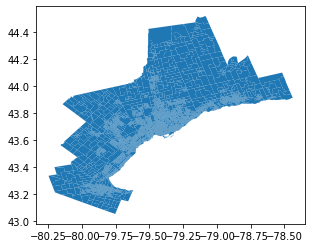

In [9]:
t = time()

# locally saved version of the Census Profiles of Income dataset
da_gdf = gpd.read_file(da_path + 'da_census_income.shp')

elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(da_gdf.shape[0], da_gdf.shape[1]) + 
      "\n-- Column names:\n", da_gdf.columns)

cols = ['DAUID', 'CSDUID', 'CSDNAME', 'geometry']
da_gdf = da_gdf[cols]

print("Taking the subset with columns\n:", cols)

print("\n-- New column names:\n", da_gdf.columns)

da_gdf.plot();

## Load Teranet data

In [10]:
t = time()
teranet_df = pd.read_csv(teranet_path + 'HHSaleHistory.csv',
                         na_values=" ")
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

----- DataFrame loaded
in 21.15 seconds
with 9,039,241 rows
and 15 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 122.68 seconds (2.04 minutes)
with 9,039,241 rows
and 16 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'geometry'],
      dtype='object')

----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!


## Add validation key `val_transaction_id`
Attribute `val_transaction_id` is intended as a unique identifier for each record in the Teranet dataset prior to the spatial join with Dissemination Areas. It will be used as the **_primary key_** to count the number of unique Teranet transactions in the joined dataset. In this step, Teranet dataset is being cropped by GTHA boundary, but duplicates may appear if a Teranet record spatially matches more than one DA polygon. Column will be removed after the validation is performed at the end of the spatial join in this step.
    
`val_transaction_id` is essentially a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`

**_Surrogate key_** `transaction_id` will be added after the spatial join, to index transactions in the cropped dataset (performed at the end of this notebook).
### Order Teranet records by `registration_date` and `pin`

In [11]:
teranet_gdf = teranet_gdf.sort_values(['registration_date', 'pin'])
print("GeoDataFrame was resorted by 'registration_date' and 'pin'.")

GeoDataFrame was resorted by 'registration_date' and 'pin'.


### Insert the new column `transaction_id`

In [12]:
teranet_gdf.insert(0, "val_transaction_id", np.arange(len(teranet_gdf)))
print("New column 'val_transaction_id' was added to the GeoDataFrame.")

New column 'val_transaction_id' was added to the GeoDataFrame.


## Perform the spatial join of Teranet points with DA polygons
### Validate projections

In [13]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [14]:
da_gdf.crs

{'init': 'epsg:4326'}

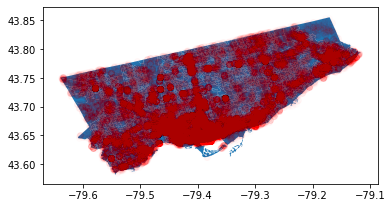

In [15]:
# plot DA polygon for Toronto
ax = da_gdf.query("CSDNAME == 'Toronto'").plot()
# plot Teranet records for Toronto
teranet_gdf.query("MUNICIPALITY == 'Toronto'").plot(ax=ax, color='red', alpha=0.01)

### Perform the spatial join

In [16]:
t = time()
teranet_da_gdf = gpd.sjoin(teranet_gdf.to_crs(da_gdf.crs), da_gdf, 
                           how='inner', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_da_gdf.shape[0], teranet_da_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_da_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 1204.14 seconds (20.07 minutes)
with 6,803,691 rows
and 21 columns
-- Column names:
 Index(['val_transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'geometry', 'index_right',
       'DAUID', 'CSDUID', 'CSDNAME'],
      dtype='object')


### Validate the number of unique Teranet records in the joined dataset using `val_transaction_id`
No duplicated Teranet records are being produced by this spatial join.

In [17]:
len(teranet_da_gdf)

6803691

In [18]:
teranet_da_gdf['val_transaction_id'].nunique()

6803691

In [19]:
teranet_da_gdf = teranet_da_gdf.drop('val_transaction_id', axis=1)
print("Column 'val_transaction_id' was dropped.")

Column 'val_transaction_id' was dropped.


## Add surrogate key `transaction_id`
Attribute `transaction_id` is intended as a unique identifier for each record in the Teranet dataset. It will be used as the **_primary key_** for records in Teranet table in the proposed GTHA housing market database. It is produced as a surrogate key, as no other attribute or combination of attributes in the Teranet dataset allows the records to be uniquely identified. 
    
`transaction_id` is essentially a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`

**_Surrogate key_** `transaction_id` is added prior to the removal of any records, so that the keys match between both versions of the Teranet dataset -- the one with unmodified `consideration_amt` and the one where records with `consideration_amt` < 10'000 CAD have been dropped.
### Order Teranet records by `registration_date` and `pin`

In [20]:
teranet_da_gdf = teranet_da_gdf.sort_values(['registration_date', 'pin'])
print("GeoDataFrame was resorted by 'registration_date' and 'pin'.")

GeoDataFrame was resorted by 'registration_date' and 'pin'.


### Insert the new column `transaction_id`

In [21]:
teranet_da_gdf.insert(0, "transaction_id", np.arange(len(teranet_da_gdf)))
print("New column 'transaction_id' was added to the GeoDataFrame.")

New column 'transaction_id' was added to the GeoDataFrame.


## Save results to a .csv file

In [22]:
save_path = teranet_path + '1.1_Teranet_DA.csv'
t = time()
teranet_da_gdf.drop(['index_right', 'geometry'], axis=1).to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/1.1_Teranet_DA.csv 
took 133.37 seconds (2.22 minutes)
